In [1]:
import torch
print(torch.cuda.get_device_name(0))
print(torch.cuda.is_available())
print(torch.__version__)

GeForce RTX 2080 Ti
True
1.2.0


In [2]:
# https://greeksharifa.github.io/pytorch/2018/11/10/pytorch-usage-03-How-to-Use-PyTorch/
# https://www.kaggle.com/corochann/bengali-seresnext-training-with-pytorch
# https://9bow.github.io/PyTorch-tutorials-kr-0.3.1/beginner/transfer_learning_tutorial.html
# https://www.kaggle.com/phoenix9032/pytorch-efficientnet-starter-code

In [3]:
import argparse
import os

# load data

from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# train
from torch import nn
from torch.nn import functional as F

# visualization
import matplotlib.pyplot as plt

import pandas as pd
import gc
import numpy as np

In [4]:
# argparse 란
# python train.py --epochs 50 --batch-size 64 --save-dir weights
# 터미널에서 arg를 넘겨주도록 설정해주는 라이브러리

In [5]:
image_size = 128
batch_size = 64
model_name = 'se_resnext50_32x4d'
trainset = True
datapath = 'bengaliai-cv19/'
featherpath = 'bengaliai-cv19/bengaliaicv19feather/'
device = 'cuda:0'

## Prepare Data


In [6]:
indices = [0,1,2,3]

train = pd.read_csv(datapath+'train.csv')
train_labels = train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values
indices = [0, 1, 2, 3]


if trainset :
    img = [pd.read_feather(featherpath+'train_image_data_%s.feather'%i) for i in indices]
    HEIGHT, WIDTH = 137,236
    images = [df.iloc[:,1:].values.reshape(-1,HEIGHT,WIDTH) for df in img]
    del img
    gc.collect()
    images = np.concatenate(images, axis = 0)
else :
    img = [pd.read_parquet(datapath+'test_image_data_%s.feather'%i) for i in indices]
    HEIGHT, WIDTH = 137,236
    images = [df.iloc[:,1:].values.reshape(-1,HEIGHT,WIDTH) for df in img]
    del img
    gc.collect()
    images = np.concatenate(images, axis = 0)

In [7]:
images[99]

array([[246, 247, 246, ..., 239, 237, 249],
       [249, 245, 244, ..., 249, 242, 245],
       [245, 249, 253, ..., 252, 252, 247],
       ...,
       [255, 254, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 254, 254, 254],
       [254, 253, 255, ..., 254, 254, 254]], dtype=uint8)

## Load Data

In [132]:
### torch.utils.data.DataLoader
# DataLoader 객체는 학습에 쓰일 데이터 전체를 보관했다가. 
# train 함수가 batch 하나를 요구하면 Batch size 만큼 꺼내준다. 
# 실제로 먼저 잘라 놓는 것은 아니고 index가 존재한다.

# DataLoader는 datasets, transforms 등 의 함수를 포함한다.

# https://tutorials.pytorch.kr/beginner/data_loading_tutorial.html
# Custom Dataset 만들기
# torch.utils.data.Dataset을 상속해야한다.
# len(dataset) 에서 호출 되는 __len__ 은 데이터셋의 크기를 리턴
# dataset[i]에서 호출되는 __getitem__은 i번째 샘플을 차즌데 사용

# __init__으로 csv 파일 안에 있는 데이터를 읽지만, __getitem__을 이용해 이미지 판독
# 이는 모든 이미지를 메모리에 저장하지 않고 필요할 때마다 읽기 때문에 메모리를 효율적으로 사용


from torch.utils.data.dataset import Dataset

# https://tutorials.pytorch.kr/beginner/data_loading_tutorial.html
class BengaliDataset(Dataset):
    def __init__(self, images,labels = None, transform = None):
        self.images = images
        self.labels = labels
        self.transform = transform
#         print(self.images)
        """
        Args:
            images = 앞에서 images set을 만들어서 넣어 주는 것
            transform (callable, optional): 샘플에 적용될 Optional transform
        """

    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()            
        """
            idx에 해당하는 image와 label(3개)를 return 
        """
        # Opposite white and black: background will be white and
        # for future Affine transformation
        img =(255 - self.images[idx]).astype(np.float32)# / 255.
        
        if self.transform : 
            img = resize(img)
            img = crop_char_image(img)
            img = affine_image(img)
        else :  # size만 바꾸는 것
            img = resize(img)
            
        if self.labels is None :
            return img
        else : 
            return img, self.labels[idx][0],self.labels[idx][1],self.labels[idx][2]


# Transformation : 
### Data Augmentation/ preprocessing/ rescale/randomcrop

In [9]:


# https://tutorials.pytorch.kr/beginner/data_loading_tutorial.html

In [10]:
# # Rescale
# # 주어진 사이즈로 샘플 크기를 조정합니다. 

"""
From https://www.kaggle.com/corochann/deep-learning-cnn-with-chainer-lb-0-99700
"""
import cv2
from skimage.transform import AffineTransform, warp
import numpy as np

def resize(image, size=(128, 128)):
    return cv2.resize(image, size)



In [11]:
# Cropping
def crop_char_image(image, threshold=5./255.):
    assert image.ndim == 2
    is_black = image > threshold

    is_black_vertical = np.sum(is_black, axis=0) > 0
    is_black_horizontal = np.sum(is_black, axis=1) > 0
    left = np.argmax(is_black_horizontal)
    right = np.argmax(is_black_horizontal[::-1])
    top = np.argmax(is_black_vertical)
    bottom = np.argmax(is_black_vertical[::-1])
    height, width = image.shape
    cropped_image = image[left:height - right, top:width - bottom]
    return cropped_image

In [12]:
# Affine_image 
# 선형변환에서 이동변환까지 포함하여 Affine 변환이라고 한다. 
#
def affine_image(img):
    """

    Args:
        img: (h, w) or (1, h, w)

    Returns:
        img: (h, w)
    """
    # ch, h, w = img.shape
    # img = img / 255.
    if img.ndim == 3:
        img = img[0]

    # --- scale ---
    min_scale = 0.8
    max_scale = 1.2
    sx = np.random.uniform(min_scale, max_scale)
    sy = np.random.uniform(min_scale, max_scale)

    # --- rotation ---
    max_rot_angle = 7
    rot_angle = np.random.uniform(-max_rot_angle, max_rot_angle) * np.pi / 180.

    # --- shear ---
    max_shear_angle = 10
    shear_angle = np.random.uniform(-max_shear_angle, max_shear_angle) * np.pi / 180.

    # --- translation ---
    max_translation = 4
    tx = np.random.randint(-max_translation, max_translation)
    ty = np.random.randint(-max_translation, max_translation)

    tform = AffineTransform(scale=(sx, sy), rotation=rot_angle, shear=shear_angle,
                            translation=(tx, ty))
    transformed_image = warp(img, tform)
    assert transformed_image.ndim == 2
    return transformed_image

In [13]:
train_transform =transforms.Compose([
        transforms.RandomResizedCrop(224)])

In [133]:
train_dataset =BengaliDataset(images, train_labels, transform= True)





30it [00:00, 624.43it/s]


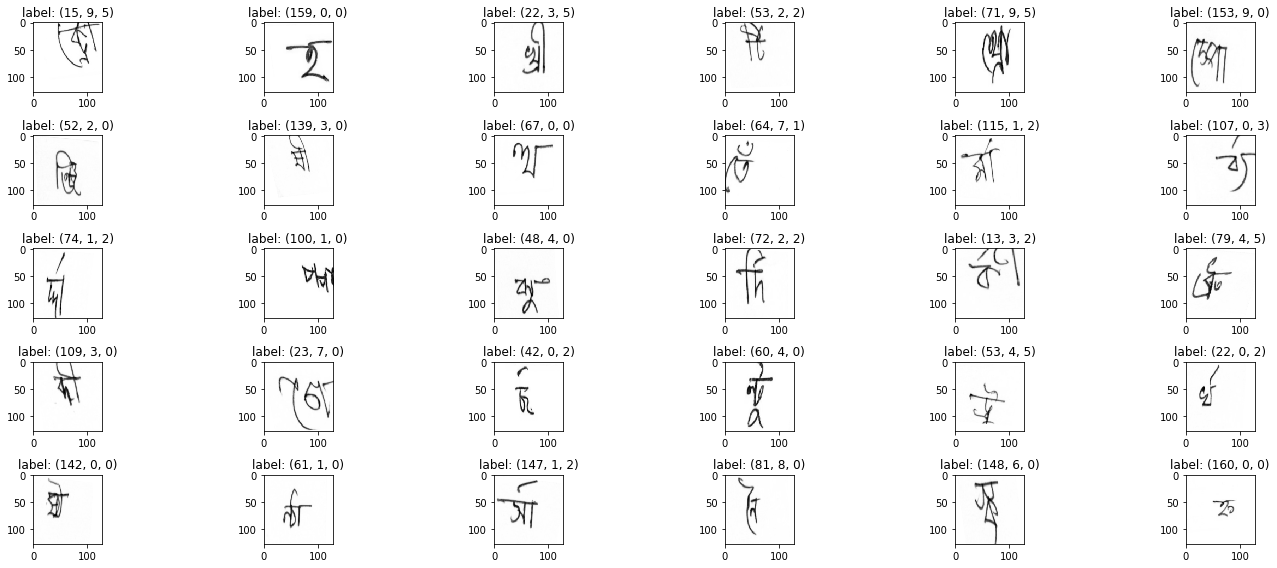

In [141]:
nrow, ncol = 5, 6

from tqdm import tqdm

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label0,label1,label2 = train_dataset[i]
    ax.imshow(image, cmap='Greys')
    ax.set_title(f'label: {label0, label1, label2}')
plt.tight_layout()
plt.show()


### train_test set 분리

In [93]:
%%time
## Do a train-valid split of the data to create dataset and dataloader . Specify random seed to get reproducibility 
from sklearn.model_selection import train_test_split
train_df , valid_df = train_test_split(train_labels,test_size=0.20, random_state=42,shuffle=True) ## Split Labels
images_train, images_valid = train_test_split(images,test_size=0.20, random_state=42,shuffle=True) ## Split Labels


train_dataset = BengaliDataset(images_train, train_df, transform= True)
valid_dataset = BengaliDataset(images_valid, valid_df, transform= False)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)#, num_workers = 8)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)#, num_workers = 8)
# images_train, images_valid = images[train_df.index], images[valid_df.index]

# del images
# gc.collect()

Wall time: 3min 47s


In [ ]:
# https://towardsdatascience.com/how-to-train-an-image-classifier-in-pytorch-and-use-it-to-perform-basic-inference-on-single-images-99465a1e9bf5


# Modeling

In [19]:
# http://incredible.ai/artificial-intelligence/2017/05/13/Transfer-Learning/
# Inception Test
# https://greeksharifa.github.io/pytorch/2018/11/10/pytorch-usage-03-How-to-Use-PyTorch/#%EB%AA%A8%EB%8D%B8-%EA%B5%AC%EC%84%B1-%EB%B0%A9%EB%B2%95

In [32]:
# # https://dnddnjs.github.io/cifar10/2018/10/09/resnet/

# from torchvision import transforms,models
# #Resnet 50
# class Identity(torch.nn.Module):
#     def __init__(self):
#         super(Identity, self).__init__()
        
#     def forward(self, x):
#         return x

# def resnet50():
#     res50 = models.resnet50(pretrained=True)
#     res50.fc = Identity() 
#     res50.avgpool = Identity() 
#     return res50
    
    
# class ResNet50(torch.nn.Module):
#     def __init__(self,):
#         super(ResNet50, self).__init__()
#         self.resnet50 = resnet50()
#         self.avgpool = nn.AvgPool2d(2)
#         # vowel_diacritic
#         self.fc1 = nn.Linear(32768,11)
#         # grapheme_root
#         self.fc2 = nn.Linear(32768,168)
#         # consonant_diacritic
#         self.fc3 = nn.Linear(32768,7)
        
#     def forward(self, x):
#         x = self.resnet50(x)
#         # x = self.avgpool(x)
#         x = x.view(x.size(0),-1)
#         x1 = self.fc1(x)
#         x2 = self.fc2(x)
#         x3 = self.fc3(x)
#         return x1,x2,x3


In [33]:
# model = ResNet50().to(device)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to C:\Users\yseon/.cache\torch\checkpoints\resnet50-19c8e357.pth
100%|█████████████████████████████████████████████████████████████████████████████| 97.8M/97.8M [00:09<00:00, 10.7MB/s]


In [34]:
# # https://www.kaggle.com/khoongweihao/resnet-34-pytorch-starter-kit
# optimizer = optimizer = torch.optim.Adam(model.parameters(), lr=4e-4)
# #scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-4, max_lr=0.05)
# criterion = nn.CrossEntropyLoss()

In [156]:
import torch


def residual_add(lhs, rhs):
    lhs_ch, rhs_ch = lhs.shape[1], rhs.shape[1]
    if lhs_ch < rhs_ch:
        out = lhs + rhs[:, :lhs_ch]
    elif lhs_ch > rhs_ch:
        out = torch.cat([lhs[:, :rhs_ch] + rhs, lhs[:, rhs_ch:]], dim=1)
    else:
        out = lhs + rhs
    return out

In [157]:
from typing import List

import torch
from torch import nn
from torch.nn.parameter import Parameter


class LazyLoadModule(nn.Module):
    """Lazy buffer/parameter loading using load_state_dict_pre_hook

    Define all buffer/parameter in `_lazy_buffer_keys`/`_lazy_parameter_keys` and
    save buffer with `register_buffer`/`register_parameter`
    method, which can be outside of __init__ method.
    Then this module can load any shape of Tensor during de-serializing.

    Note that default value of lazy buffer is torch.Tensor([]), while lazy parameter is None.
    """
    _lazy_buffer_keys: List[str] = []     # It needs to be override to register lazy buffer
    _lazy_parameter_keys: List[str] = []  # It needs to be override to register lazy parameter

    def __init__(self):
        super(LazyLoadModule, self).__init__()
        for k in self._lazy_buffer_keys:
            self.register_buffer(k, torch.tensor([]))
        for k in self._lazy_parameter_keys:
            self.register_parameter(k, None)
        self._register_load_state_dict_pre_hook(self._hook)

    def _hook(self, state_dict, prefix, local_metadata, strict, missing_keys,
             unexpected_keys, error_msgs):
        for key in self._lazy_buffer_keys:
            self.register_buffer(key, state_dict[prefix + key])

        for key in self._lazy_parameter_keys:
            self.register_parameter(key, Parameter(state_dict[prefix + key]))

In [158]:
import math
import torch
from torch.nn import init
from torch.nn.parameter import Parameter
import torch.nn.functional as F


class LazyLinear(LazyLoadModule):
    """Linear module with lazy input inference

    `in_features` can be `None`, and it is determined at the first time of forward step dynamically.
    """

    __constants__ = ['bias', 'in_features', 'out_features']
    _lazy_parameter_keys = ['weight']

    def __init__(self, in_features, out_features, bias=True):
        super(LazyLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        if bias:
            self.bias = Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)

        if in_features is not None:
            self.weight = Parameter(torch.Tensor(out_features, in_features))
            self.reset_parameters()

    def reset_parameters(self):
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

    def forward(self, input):
        if self.weight is None:
            self.in_features = input.shape[-1]
            self.weight = Parameter(torch.Tensor(self.out_features, self.in_features))
            self.reset_parameters()

            # Need to send lazy defined parameter to device...
            self.to(input.device)
        return F.linear(input, self.weight, self.bias)

    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )

In [159]:
from torch import nn
import torch.nn.functional as F


class LinearBlock(nn.Module):

    def __init__(self, in_features, out_features, bias=True,
                 use_bn=True, activation=F.relu, dropout_ratio=-1, residual=False,):
        super(LinearBlock, self).__init__()
        if in_features is None:
            self.linear = LazyLinear(in_features, out_features, bias=bias)
        else:
            self.linear = nn.Linear(in_features, out_features, bias=bias)
        if use_bn:
            self.bn = nn.BatchNorm1d(out_features)
        if dropout_ratio > 0.:
            self.dropout = nn.Dropout(p=dropout_ratio)
        else:
            self.dropout = None
        self.activation = activation
        self.use_bn = use_bn
        self.dropout_ratio = dropout_ratio
        self.residual = residual

    def __call__(self, x):
        h = self.linear(x)
        if self.use_bn:
            h = self.bn(h)
        if self.activation is not None:
            h = self.activation(h)
        if self.residual:
            h = residual_add(h, x)
        if self.dropout_ratio > 0:
            h = self.dropout(h)
        return h

In [160]:
import pretrainedmodels
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import Sequential


class PretrainedCNN(nn.Module):
    def __init__(self, model_name='se_resnext101_32x4d',
                 in_channels=1, out_dim=10, use_bn=True,
                 pretrained='imagenet'):
        super(PretrainedCNN, self).__init__()
        self.conv0 = nn.Conv2d(
            in_channels, 3, kernel_size=3, stride=1, padding=1, bias=True)
        self.base_model = pretrainedmodels.__dict__[model_name](pretrained=pretrained)
        activation = F.leaky_relu
        self.do_pooling = True
        if self.do_pooling:
            inch = self.base_model.last_linear.in_features
        else:
            inch = None
        hdim = 512
        lin1 = LinearBlock(inch, hdim, use_bn=use_bn, activation=activation, residual=False)
        lin2 = LinearBlock(hdim, out_dim, use_bn=use_bn, activation=None, residual=False)
        self.lin_layers = Sequential(lin1, lin2)

    def forward(self, x):
        h = self.conv0(x)
        h = self.base_model.features(h)

        if self.do_pooling:
            h = torch.sum(h, dim=(-1, -2))
        else:
            # [128, 2048, 4, 4] when input is (128, 128)
            bs, ch, height, width = h.shape
            h = h.view(bs, ch*height*width)
        for layer in self.lin_layers:
            h = layer(h)
        return h

In [162]:
import torch
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm


def accuracy(y, t):
    pred_label = torch.argmax(y, dim=1)
    count = pred_label.shape[0]
    correct = (pred_label == t).sum().type(torch.float32)
    acc = correct / count
    return acc


class BengaliClassifier(nn.Module):
    def __init__(self, predictor, n_grapheme=168, n_vowel=11, n_consonant=7):
        super(BengaliClassifier, self).__init__()
        self.n_grapheme = n_grapheme
        self.n_vowel = n_vowel
        self.n_consonant = n_consonant
        self.n_total_class = self.n_grapheme + self.n_vowel + self.n_consonant
        self.predictor = predictor

        self.metrics_keys = [
            'loss', 'loss_grapheme', 'loss_vowel', 'loss_consonant',
            'acc_grapheme', 'acc_vowel', 'acc_consonant']

    def forward(self, x, y=None):
        pred = self.predictor(x)
        if isinstance(pred, tuple):
            assert len(pred) == 3
            preds = pred
        else:
            assert pred.shape[1] == self.n_total_class
            preds = torch.split(pred, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        loss_grapheme = F.cross_entropy(preds[0], y[:, 0])
        loss_vowel = F.cross_entropy(preds[1], y[:, 1])
        loss_consonant = F.cross_entropy(preds[2], y[:, 2])
        loss = loss_grapheme + loss_vowel + loss_consonant
        metrics = {
            'loss': loss.item(),
            'loss_grapheme': loss_grapheme.item(),
            'loss_vowel': loss_vowel.item(),
            'loss_consonant': loss_consonant.item(),
            'acc_grapheme': accuracy(preds[0], y[:, 0]),
            'acc_vowel': accuracy(preds[1], y[:, 1]),
            'acc_consonant': accuracy(preds[2], y[:, 2]),
        }
        return loss, metrics, pred

    def calc(self, data_loader):
        device: torch.device = next(self.parameters()).device
        self.eval()
        output_list = []
        with torch.no_grad():
            for batch in tqdm(data_loader):
                # TODO: support general preprocessing.
                # If `data` is not `Data` instance, `to` method is not supported!
                batch = batch.to(device)
                pred = self.predictor(batch)
                output_list.append(pred)
        output = torch.cat(output_list, dim=0)
        preds = torch.split(output, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        return preds

    def predict_proba(self, data_loader):
        preds = self.calc(data_loader)
        return [F.softmax(p, dim=1) for p in preds]

    def predict(self, data_loader):
        preds = self.calc(data_loader)
        pred_labels = [torch.argmax(p, dim=1) for p in preds]
        return pred_labels

In [167]:
# n_dataset = len(images)
# train_data_size = int(n_dataset * 0.9)
# valid_data_size = int(n_dataset - train_data_size)

# perm = np.random.RandomState(777).permutation(n_dataset)
# print('perm', perm)
# train_dataset = BengaliDataset(
#     images, train_labels, transform=True,
#     indices=perm[:train_data_size])
# valid_dataset = BengaliAIDataset(
#     images, train_labels, transform=False,
#     indices=perm[train_data_size:train_data_size+valid_data_size])
# print('train_dataset', len(train_dataset), 'valid_dataset', len(valid_dataset))

perm [ 95762  34576  11800 ... 183206 113455  63591]


TypeError: __init__() got an unexpected keyword argument 'indices'

In [168]:
%%time
## Do a train-valid split of the data to create dataset and dataloader . Specify random seed to get reproducibility 
from sklearn.model_selection import train_test_split
train_df , valid_df = train_test_split(train_labels,test_size=0.20, random_state=42,shuffle=True) ## Split Labels
images_train, images_valid = train_test_split(images,test_size=0.20, random_state=42,shuffle=True) ## Split Labels


train_dataset = BengaliDataset(images_train, train_df, transform= True)
valid_dataset = BengaliDataset(images_valid, valid_df, transform= False)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)#, num_workers = 8)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)#, num_workers = 8)
# images_train, images_valid = images[train_df.index], images[valid_df.index]

# del images
# gc.collect()

Wall time: 3min 49s


In [169]:
# --- Model ---
device = torch.device(device)
n_grapheme = 168
n_vowel = 11
n_consonant = 7
n_total = n_grapheme + n_vowel + n_consonant
print('n_total', n_total)
# Set pretrained='imagenet' to download imagenet pretrained model...
predictor = PretrainedCNN(in_channels=1, out_dim=n_total, model_name=model_name, pretrained='imagenet')
print('predictor', type(predictor))

classifier = BengaliClassifier(predictor).to(device)

n_total 186


Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/se_resnext50_32x4d-a260b3a4.pth" to C:\Users\yseon/.cache\torch\checkpoints\se_resnext50_32x4d-a260b3a4.pth




  0%|                                                                                       | 0.00/105M [00:00<?, ?B/s]



  0%|                                                                            | 8.00k/105M [00:00<1:02:48, 29.3kB/s]



  0%|                                                                              | 24.0k/105M [00:00<51:02, 36.1kB/s]



  0%|                                                                              | 56.0k/105M [00:00<40:43, 45.2kB/s]



  0%|                                                                               | 136k/105M [00:01<30:28, 60.4kB/s]



  0%|▏                                                                              | 216k/105M [00:01<22:03, 83.4kB/s]



  0%|▏                                                                               | 264k/

  4%|██▊                                                                            | 3.84M/105M [00:11<04:59, 356kB/s]



  4%|██▉                                                                            | 3.90M/105M [00:12<05:03, 351kB/s]



  4%|██▉                                                                            | 3.97M/105M [00:12<04:58, 357kB/s]



  4%|███                                                                            | 4.04M/105M [00:12<04:55, 360kB/s]



  4%|███                                                                            | 4.11M/105M [00:12<04:53, 362kB/s]



  4%|███▏                                                                           | 4.17M/105M [00:12<05:04, 348kB/s]



  4%|███▏                                                                           | 4.24M/105M [00:13<05:00, 354kB/s]



  4%|███▏                                                                           | 4.31M/105M [00:13<04:59, 354kB/s]



  4%|███▎       

  8%|█████▉                                                                         | 7.94M/105M [00:23<04:43, 361kB/s]



  8%|█████▉                                                                         | 8.00M/105M [00:24<04:52, 349kB/s]



  8%|██████                                                                         | 8.07M/105M [00:24<04:47, 355kB/s]



  8%|██████                                                                         | 8.14M/105M [00:24<04:45, 357kB/s]



  8%|██████▏                                                                        | 8.21M/105M [00:24<04:42, 360kB/s]



  8%|██████▏                                                                        | 8.27M/105M [00:24<04:57, 342kB/s]



  8%|██████▎                                                                        | 8.34M/105M [00:25<04:46, 356kB/s]



  8%|██████▎                                                                        | 8.41M/105M [00:25<04:45, 356kB/s]



  8%|██████▎    

 11%|█████████                                                                      | 12.0M/105M [00:36<04:32, 360kB/s]



 11%|█████████                                                                      | 12.1M/105M [00:36<04:39, 350kB/s]



 12%|█████████                                                                      | 12.2M/105M [00:36<04:37, 353kB/s]



 12%|█████████▏                                                                     | 12.2M/105M [00:36<04:34, 356kB/s]



 12%|█████████▏                                                                     | 12.3M/105M [00:36<04:35, 355kB/s]



 12%|█████████▎                                                                     | 12.4M/105M [00:37<04:45, 342kB/s]



 12%|█████████▎                                                                     | 12.4M/105M [00:37<04:36, 353kB/s]



 12%|█████████▍                                                                     | 12.5M/105M [00:37<04:38, 350kB/s]



 12%|█████████▍ 

 15%|████████████                                                                   | 16.1M/105M [00:48<04:20, 359kB/s]



 15%|████████████▏                                                                  | 16.2M/105M [00:48<04:29, 348kB/s]



 15%|████████████▏                                                                  | 16.3M/105M [00:48<04:23, 355kB/s]



 16%|████████████▏                                                                  | 16.3M/105M [00:48<04:25, 352kB/s]



 16%|████████████▎                                                                  | 16.4M/105M [00:48<04:19, 359kB/s]



 16%|████████████▎                                                                  | 16.5M/105M [00:49<04:26, 349kB/s]



 16%|████████████▍                                                                  | 16.5M/105M [00:49<04:24, 353kB/s]



 16%|████████████▍                                                                  | 16.6M/105M [00:49<04:22, 355kB/s]



 16%|███████████

 19%|███████████████                                                                | 20.2M/105M [01:00<04:10, 357kB/s]



 19%|███████████████▏                                                               | 20.2M/105M [01:00<04:07, 361kB/s]



 19%|███████████████▏                                                               | 20.3M/105M [01:00<04:20, 342kB/s]



 19%|███████████████▎                                                               | 20.4M/105M [01:00<04:21, 342kB/s]



 19%|███████████████▎                                                               | 20.4M/105M [01:00<04:07, 360kB/s]



 19%|███████████████▎                                                               | 20.5M/105M [01:01<04:03, 366kB/s]



 20%|███████████████▍                                                               | 20.6M/105M [01:01<04:12, 352kB/s]



 20%|███████████████▍                                                               | 20.6M/105M [01:01<04:09, 357kB/s]



 20%|███████████

 23%|██████████████████▏                                                            | 24.3M/105M [01:12<03:55, 361kB/s]



 23%|██████████████████▏                                                            | 24.3M/105M [01:12<03:54, 363kB/s]



 23%|██████████████████▎                                                            | 24.4M/105M [01:12<04:02, 350kB/s]



 23%|██████████████████▎                                                            | 24.5M/105M [01:12<03:58, 356kB/s]



 23%|██████████████████▍                                                            | 24.5M/105M [01:12<03:56, 359kB/s]



 23%|██████████████████▍                                                            | 24.6M/105M [01:13<03:58, 355kB/s]



 23%|██████████████████▍                                                            | 24.7M/105M [01:13<04:07, 342kB/s]



 23%|██████████████████▌                                                            | 24.8M/105M [01:13<04:02, 348kB/s]



 24%|███████████

 27%|█████████████████████▎                                                         | 28.4M/105M [01:24<03:46, 356kB/s]



 27%|█████████████████████▎                                                         | 28.4M/105M [01:24<03:48, 353kB/s]



 27%|█████████████████████▎                                                         | 28.5M/105M [01:24<03:52, 347kB/s]



 27%|█████████████████████▍                                                         | 28.6M/105M [01:24<03:51, 348kB/s]



 27%|█████████████████████▍                                                         | 28.6M/105M [01:25<03:48, 352kB/s]



 27%|█████████████████████▌                                                         | 28.7M/105M [01:25<03:46, 355kB/s]



 27%|█████████████████████▌                                                         | 28.8M/105M [01:25<03:44, 357kB/s]



 27%|█████████████████████▌                                                         | 28.9M/105M [01:25<03:42, 361kB/s]



 27%|███████████

 31%|████████████████████████▎                                                      | 32.5M/105M [01:36<03:33, 358kB/s]



 31%|████████████████████████▍                                                      | 32.5M/105M [01:36<03:32, 360kB/s]



 31%|████████████████████████▍                                                      | 32.6M/105M [01:36<03:40, 346kB/s]



 31%|████████████████████████▍                                                      | 32.7M/105M [01:36<03:41, 344kB/s]



 31%|████████████████████████▌                                                      | 32.8M/105M [01:37<03:39, 348kB/s]



 31%|████████████████████████▌                                                      | 32.8M/105M [01:37<03:31, 360kB/s]



 31%|████████████████████████▋                                                      | 32.9M/105M [01:37<03:33, 356kB/s]



 31%|████████████████████████▋                                                      | 33.0M/105M [01:37<03:31, 359kB/s]



 31%|███████████

 35%|███████████████████████████▍                                                   | 36.6M/105M [01:48<03:21, 358kB/s]



 35%|███████████████████████████▍                                                   | 36.6M/105M [01:48<03:20, 360kB/s]



 35%|███████████████████████████▌                                                   | 36.7M/105M [01:48<03:29, 344kB/s]



 35%|███████████████████████████▌                                                   | 36.8M/105M [01:48<03:22, 355kB/s]



 35%|███████████████████████████▌                                                   | 36.9M/105M [01:49<03:20, 358kB/s]



 35%|███████████████████████████▋                                                   | 36.9M/105M [01:49<03:22, 355kB/s]



 35%|███████████████████████████▋                                                   | 37.0M/105M [01:49<03:28, 344kB/s]



 35%|███████████████████████████▊                                                   | 37.1M/105M [01:49<03:24, 350kB/s]



 35%|███████████

 39%|██████████████████████████████▍                                                | 40.7M/105M [02:00<03:11, 354kB/s]



 39%|██████████████████████████████▌                                                | 40.8M/105M [02:00<03:08, 361kB/s]



 39%|██████████████████████████████▌                                                | 40.8M/105M [02:00<03:11, 354kB/s]



 39%|██████████████████████████████▋                                                | 40.9M/105M [02:01<03:11, 354kB/s]



 39%|██████████████████████████████▋                                                | 41.0M/105M [02:01<03:07, 361kB/s]



 39%|██████████████████████████████▋                                                | 41.0M/105M [02:01<03:08, 359kB/s]



 39%|██████████████████████████████▊                                                | 41.1M/105M [02:01<03:12, 351kB/s]



 39%|██████████████████████████████▊                                                | 41.2M/105M [02:01<03:12, 351kB/s]



 39%|███████████

 42%|█████████████████████████████████▌                                             | 44.8M/105M [02:12<02:59, 354kB/s]



 43%|█████████████████████████████████▌                                             | 44.9M/105M [02:12<02:55, 363kB/s]



 43%|█████████████████████████████████▋                                             | 44.9M/105M [02:12<03:00, 351kB/s]



 43%|█████████████████████████████████▋                                             | 45.0M/105M [02:13<03:01, 349kB/s]



 43%|█████████████████████████████████▊                                             | 45.1M/105M [02:13<02:56, 358kB/s]



 43%|█████████████████████████████████▊                                             | 45.1M/105M [02:13<02:56, 359kB/s]



 43%|█████████████████████████████████▊                                             | 45.2M/105M [02:13<03:01, 348kB/s]



 43%|█████████████████████████████████▉                                             | 45.3M/105M [02:13<02:58, 354kB/s]



 43%|███████████

 46%|████████████████████████████████████▋                                          | 48.9M/105M [02:24<02:47, 353kB/s]



 46%|████████████████████████████████████▋                                          | 49.0M/105M [02:24<02:44, 361kB/s]



 46%|████████████████████████████████████▋                                          | 49.0M/105M [02:25<02:47, 353kB/s]



 47%|████████████████████████████████████▊                                          | 49.1M/105M [02:25<02:45, 356kB/s]



 47%|████████████████████████████████████▊                                          | 49.2M/105M [02:25<02:42, 364kB/s]



 47%|████████████████████████████████████▉                                          | 49.2M/105M [02:25<02:43, 362kB/s]



 47%|████████████████████████████████████▉                                          | 49.3M/105M [02:25<02:47, 351kB/s]



 47%|████████████████████████████████████▉                                          | 49.4M/105M [02:26<02:45, 355kB/s]



 47%|███████████

 50%|███████████████████████████████████████▋                                       | 53.0M/105M [02:36<02:34, 356kB/s]



 50%|███████████████████████████████████████▊                                       | 53.1M/105M [02:36<02:30, 365kB/s]



 50%|███████████████████████████████████████▊                                       | 53.1M/105M [02:37<02:35, 352kB/s]



 50%|███████████████████████████████████████▊                                       | 53.2M/105M [02:37<02:32, 358kB/s]



 51%|███████████████████████████████████████▉                                       | 53.3M/105M [02:37<02:35, 353kB/s]



 51%|███████████████████████████████████████▉                                       | 53.3M/105M [02:37<02:31, 360kB/s]



 51%|████████████████████████████████████████                                       | 53.4M/105M [02:37<02:34, 354kB/s]



 51%|████████████████████████████████████████                                       | 53.5M/105M [02:38<02:33, 354kB/s]



 51%|███████████

 54%|██████████████████████████████████████████▊                                    | 57.1M/105M [02:48<02:22, 355kB/s]



 54%|██████████████████████████████████████████▊                                    | 57.2M/105M [02:49<02:21, 358kB/s]



 54%|██████████████████████████████████████████▊                                    | 57.2M/105M [02:49<02:24, 350kB/s]



 54%|██████████████████████████████████████████▉                                    | 57.3M/105M [02:49<02:20, 359kB/s]



 54%|██████████████████████████████████████████▉                                    | 57.4M/105M [02:49<02:19, 360kB/s]



 54%|███████████████████████████████████████████                                    | 57.4M/105M [02:49<02:19, 362kB/s]



 55%|███████████████████████████████████████████                                    | 57.5M/105M [02:50<02:25, 345kB/s]



 55%|███████████████████████████████████████████▏                                   | 57.6M/105M [02:50<02:21, 354kB/s]



 55%|███████████

 58%|█████████████████████████████████████████████▊                                 | 61.2M/105M [03:00<02:09, 359kB/s]



 58%|█████████████████████████████████████████████▉                                 | 61.3M/105M [03:01<02:09, 358kB/s]



 58%|█████████████████████████████████████████████▉                                 | 61.3M/105M [03:01<02:14, 345kB/s]



 58%|█████████████████████████████████████████████▉                                 | 61.4M/105M [03:01<02:11, 351kB/s]



 58%|██████████████████████████████████████████████                                 | 61.5M/105M [03:01<02:08, 359kB/s]



 58%|██████████████████████████████████████████████                                 | 61.5M/105M [03:01<02:05, 365kB/s]



 58%|██████████████████████████████████████████████▏                                | 61.6M/105M [03:02<02:11, 351kB/s]



 58%|██████████████████████████████████████████████▏                                | 61.7M/105M [03:02<02:09, 355kB/s]



 59%|███████████

 62%|████████████████████████████████████████████████▉                              | 65.3M/105M [03:12<01:57, 359kB/s]



 62%|████████████████████████████████████████████████▉                              | 65.4M/105M [03:13<01:58, 354kB/s]



 62%|█████████████████████████████████████████████████                              | 65.4M/105M [03:13<02:00, 348kB/s]



 62%|█████████████████████████████████████████████████                              | 65.5M/105M [03:13<01:58, 354kB/s]



 62%|█████████████████████████████████████████████████                              | 65.6M/105M [03:13<01:56, 359kB/s]



 62%|█████████████████████████████████████████████████▏                             | 65.6M/105M [03:13<01:56, 358kB/s]



 62%|█████████████████████████████████████████████████▏                             | 65.7M/105M [03:14<02:01, 343kB/s]



 62%|█████████████████████████████████████████████████▎                             | 65.8M/105M [03:14<01:57, 353kB/s]



 62%|███████████

 66%|███████████████████████████████████████████████████▉                           | 69.4M/105M [03:25<01:46, 354kB/s]



 66%|████████████████████████████████████████████████████                           | 69.5M/105M [03:25<01:42, 367kB/s]



 66%|████████████████████████████████████████████████████                           | 69.5M/105M [03:25<01:46, 353kB/s]



 66%|████████████████████████████████████████████████████▏                          | 69.6M/105M [03:25<01:46, 354kB/s]



 66%|████████████████████████████████████████████████████▏                          | 69.7M/105M [03:25<01:45, 354kB/s]



 66%|████████████████████████████████████████████████████▏                          | 69.7M/105M [03:26<01:45, 355kB/s]



 66%|████████████████████████████████████████████████████▎                          | 69.8M/105M [03:26<01:45, 353kB/s]



 66%|████████████████████████████████████████████████████▎                          | 69.9M/105M [03:26<01:43, 359kB/s]



 66%|███████████

 70%|██████████████████████████████████████████████████████▉                        | 73.4M/105M [03:36<01:37, 344kB/s]



 70%|███████████████████████████████████████████████████████                        | 73.4M/105M [03:36<01:35, 351kB/s]



 70%|███████████████████████████████████████████████████████                        | 73.5M/105M [03:37<01:33, 357kB/s]



 70%|███████████████████████████████████████████████████████                        | 73.6M/105M [03:37<01:35, 349kB/s]



 70%|███████████████████████████████████████████████████████▏                       | 73.6M/105M [03:37<01:38, 338kB/s]



 70%|███████████████████████████████████████████████████████▏                       | 73.7M/105M [03:37<01:32, 359kB/s]



 70%|███████████████████████████████████████████████████████▎                       | 73.8M/105M [03:37<01:20, 410kB/s]



 70%|███████████████████████████████████████████████████████▎                       | 73.8M/105M [03:38<01:21, 407kB/s]



 70%|███████████

 73%|█████████████████████████████████████████████████████████▉                     | 77.4M/105M [03:48<01:21, 360kB/s]



 73%|██████████████████████████████████████████████████████████                     | 77.5M/105M [03:48<01:24, 348kB/s]



 74%|██████████████████████████████████████████████████████████                     | 77.5M/105M [03:49<01:24, 348kB/s]



 74%|██████████████████████████████████████████████████████████▏                    | 77.6M/105M [03:49<01:22, 354kB/s]



 74%|██████████████████████████████████████████████████████████▏                    | 77.7M/105M [03:49<01:21, 355kB/s]



 74%|██████████████████████████████████████████████████████████▏                    | 77.7M/105M [03:49<01:23, 347kB/s]



 74%|██████████████████████████████████████████████████████████▎                    | 77.8M/105M [03:49<01:22, 353kB/s]



 74%|██████████████████████████████████████████████████████████▎                    | 77.9M/105M [03:50<01:21, 354kB/s]



 74%|███████████

 77%|█████████████████████████████████████████████████████████████                  | 81.5M/105M [04:00<01:11, 353kB/s]



 77%|█████████████████████████████████████████████████████████████                  | 81.6M/105M [04:00<01:13, 343kB/s]



 77%|█████████████████████████████████████████████████████████████▏                 | 81.6M/105M [04:01<01:11, 350kB/s]



 77%|█████████████████████████████████████████████████████████████▏                 | 81.7M/105M [04:01<01:09, 360kB/s]



 78%|█████████████████████████████████████████████████████████████▎                 | 81.8M/105M [04:01<01:08, 365kB/s]



 78%|█████████████████████████████████████████████████████████████▎                 | 81.8M/105M [04:01<01:12, 343kB/s]



 78%|█████████████████████████████████████████████████████████████▎                 | 81.9M/105M [04:01<01:10, 349kB/s]



 78%|█████████████████████████████████████████████████████████████▍                 | 82.0M/105M [04:02<01:08, 359kB/s]



 78%|███████████

 81%|████████████████████████████████████████████████████████████████▏              | 85.6M/105M [04:12<00:58, 358kB/s]



 81%|████████████████████████████████████████████████████████████████▏              | 85.7M/105M [04:13<00:59, 351kB/s]



 81%|████████████████████████████████████████████████████████████████▏              | 85.7M/105M [04:13<00:58, 354kB/s]



 81%|████████████████████████████████████████████████████████████████▎              | 85.8M/105M [04:13<00:58, 350kB/s]



 81%|████████████████████████████████████████████████████████████████▎              | 85.9M/105M [04:13<00:56, 360kB/s]



 81%|████████████████████████████████████████████████████████████████▍              | 85.9M/105M [04:13<00:57, 354kB/s]



 82%|████████████████████████████████████████████████████████████████▍              | 86.0M/105M [04:14<00:57, 354kB/s]



 82%|████████████████████████████████████████████████████████████████▍              | 86.1M/105M [04:14<00:57, 354kB/s]



 82%|███████████

 85%|███████████████████████████████████████████████████████████████████▏           | 89.7M/105M [04:24<00:47, 349kB/s]



 85%|███████████████████████████████████████████████████████████████████▎           | 89.8M/105M [04:25<00:47, 346kB/s]



 85%|███████████████████████████████████████████████████████████████████▎           | 89.8M/105M [04:25<00:46, 353kB/s]



 85%|███████████████████████████████████████████████████████████████████▎           | 89.9M/105M [04:25<00:46, 353kB/s]



 85%|███████████████████████████████████████████████████████████████████▍           | 90.0M/105M [04:25<00:45, 353kB/s]



 85%|███████████████████████████████████████████████████████████████████▍           | 90.0M/105M [04:25<00:46, 348kB/s]



 85%|███████████████████████████████████████████████████████████████████▌           | 90.1M/105M [04:26<00:45, 353kB/s]



 86%|███████████████████████████████████████████████████████████████████▌           | 90.2M/105M [04:26<00:44, 361kB/s]



 86%|███████████

 89%|██████████████████████████████████████████████████████████████████████▏        | 93.7M/105M [04:36<00:35, 348kB/s]



 89%|██████████████████████████████████████████████████████████████████████▏        | 93.7M/105M [04:36<00:34, 352kB/s]



 89%|██████████████████████████████████████████████████████████████████████▎        | 93.8M/105M [04:37<00:34, 359kB/s]



 89%|██████████████████████████████████████████████████████████████████████▎        | 93.9M/105M [04:37<00:34, 354kB/s]



 89%|██████████████████████████████████████████████████████████████████████▍        | 93.9M/105M [04:37<00:33, 365kB/s]



 89%|██████████████████████████████████████████████████████████████████████▍        | 94.0M/105M [04:37<00:32, 367kB/s]



 89%|██████████████████████████████████████████████████████████████████████▍        | 94.1M/105M [04:37<00:32, 365kB/s]



 89%|██████████████████████████████████████████████████████████████████████▌        | 94.1M/105M [04:38<00:34, 340kB/s]



 89%|███████████

 93%|█████████████████████████████████████████████████████████████████████████▏     | 97.8M/105M [04:48<00:23, 347kB/s]



 93%|█████████████████████████████████████████████████████████████████████████▎     | 97.8M/105M [04:48<00:22, 355kB/s]



 93%|█████████████████████████████████████████████████████████████████████████▎     | 97.9M/105M [04:49<00:21, 360kB/s]



 93%|█████████████████████████████████████████████████████████████████████████▍     | 98.0M/105M [04:49<00:21, 357kB/s]



 93%|█████████████████████████████████████████████████████████████████████████▍     | 98.0M/105M [04:49<00:21, 360kB/s]



 93%|█████████████████████████████████████████████████████████████████████████▌     | 98.1M/105M [04:49<00:21, 358kB/s]



 93%|█████████████████████████████████████████████████████████████████████████▌     | 98.2M/105M [04:49<00:21, 353kB/s]



 93%|█████████████████████████████████████████████████████████████████████████▌     | 98.2M/105M [04:50<00:22, 343kB/s]



 93%|███████████

 96%|█████████████████████████████████████████████████████████████████████████████▏  | 102M/105M [05:00<00:11, 353kB/s]



 96%|█████████████████████████████████████████████████████████████████████████████▏  | 102M/105M [05:00<00:11, 353kB/s]



 97%|█████████████████████████████████████████████████████████████████████████████▏  | 102M/105M [05:00<00:10, 353kB/s]



 97%|█████████████████████████████████████████████████████████████████████████████▎  | 102M/105M [05:00<00:10, 360kB/s]



 97%|█████████████████████████████████████████████████████████████████████████████▎  | 102M/105M [05:01<00:10, 366kB/s]



 97%|█████████████████████████████████████████████████████████████████████████████▍  | 102M/105M [05:01<00:09, 365kB/s]



 97%|█████████████████████████████████████████████████████████████████████████████▍  | 102M/105M [05:01<00:10, 351kB/s]



 97%|█████████████████████████████████████████████████████████████████████████████▍  | 102M/105M [05:01<00:09, 352kB/s]



 97%|███████████

predictor <class '__main__.PretrainedCNN'>


In [161]:
# epochs = 50 # original 50
# model.train()
# losses = []
# accs = []
# for epoch in range(epochs):
# #     reduced_index =train.groupby(['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']).apply(lambda x: x.sample(5)).image_id.values
# #     reduced_train = train.loc[train.image_id.isin(reduced_index)]
# #     reduced_data = data_full.loc[data_full.image_id.isin(reduced_index)]
# #     train_image = GraphemeDataset(reduced_data,reduced_train)
#     train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
    
#     print('epochs {}/{} '.format(epoch+1,epochs))
#     running_loss = 0.0
#     running_acc = 0.0
#     for idx, (inputs,labels1,labels2,labels3) in tqdm(enumerate(train_loader),total=len(train_loader)):
#         print(inputs,labels1,labels2,labels3)
#         inputs = inputs.to(device)
#         labels1 = labels1.to(device)
#         labels2 = labels2.to(device)
#         labels3 = labels3.to(device)
        
#         optimizer.zero_grad()
#         outputs1,outputs2,outputs3 = model(inputs.unsqueeze(1).float())
#         loss1 = criterion(outputs1,labels1)
#         loss2 = criterion(outputs2,labels2)
#         loss3 = criterion(outputs3,labels3)
#         running_loss += loss1+loss2+loss3
#         running_acc += (outputs1.argmax(1)==labels1).float().mean()
#         running_acc += (outputs2.argmax(1)==labels2).float().mean()
#         running_acc += (outputs3.argmax(1)==labels3).float().mean()
#         (loss1+loss2+loss3).backward()
#         optimizer.step()
#     #scheduler.step()
#     losses.append(running_loss/len(train_loader))
#     accs.append(running_acc/(len(train_loader)*3))
#     print('acc : {:.2f}%'.format(running_acc/(len(train_loader)*3)))
#     print('loss : {:.4f}'.format(running_loss/len(train_loader)))
# torch.save(model.state_dict(), 'resnet34_50epochs_saved_weights.pth')

In [104]:
# epochs = 50 # original 50
# model.train()
# losses = []
# accs = []
# from torch.utils.data.dataloader import DataLoader
# for epoch in range(epochs):
    
#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)#, num_workers = 8)
#     valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)#, num_workers = 8)
    
#     print('epochs {}/{} '.format(epoch+1,epochs))
#     running_loss = 0.0
#     running_acc = 0.0
#     for (inputs,labels) in train_loader:
#         inputs = inputs.to(device)
#         labels1 = labels1.to(device)
#         labels2 = labels2.to(device)
#         labels3 = labels3.to(device)
        
#         optimizer.zero_grad()
#         outputs1,outputs2,outputs3 = model(inputs.unsqueeze(1).float())
#         loss1 = criterion(outputs1,labels1)
#         loss2 = criterion(outputs2,labels2)
#         loss3 = criterion(outputs3,labels3)
#         running_loss += loss1+loss2+loss3
#         running_acc += (outputs1.argmax(1)==labels1).float().mean()
#         running_acc += (outputs2.argmax(1)==labels2).float().mean()
#         running_acc += (outputs3.argmax(1)==labels3).float().mean()
#         (loss1+loss2+loss3).backward()
#         optimizer.step()
#     #scheduler.step()
#     losses.append(running_loss/len(train_loader))
#     accs.append(running_acc/(len(train_loader)*3))
#     print('acc : {:.2f}%'.format(running_acc/(len(train_loader)*3)))
#     print('loss : {:.4f}'.format(running_loss/len(train_loader)))
# torch.save(model.state_dict(), 'resnet34_50epochs_saved_weights.pth')

epochs 1/50 


RuntimeError: invalid argument 0: Sizes of tensors must match except in dimension 0. Got 128 and 105 in dimension 2 at C:\w\1\s\tmp_conda_3.7_055457\conda\conda-bld\pytorch_1565416617654\work\aten\src\TH/generic/THTensor.cpp:689

In [105]:
train_loader